# <font color='#4C5FDA'>**Breast Cancer Detection Based on CNNs Using Thermal Imaging** </font>

Original paper by Juan Pablo Zuluaga, Zeina Al Masry, Khaled Benaggoune, Safa Meraghni & Noureddine Zerhouni: [A CNN-based methodology for breast cancer diagnosis using thermal images](https://www.tandfonline.com/doi/full/10.1080/21681163.2020.1824685)

In [33]:
#@title **Importamos librerías necesarias**

# Pytorch essentials
# import torch

# PyTorch torchvision
from torchvision.transforms import v2
# Pytorch essentials for datasets.
from torch.utils.data import Dataset, ConcatDataset

# Data manipulation
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 

## <font color='#ECA702'>**Configuración inicial para conectarnos con Kaggle**</font>

1. Instalamos kaggle. Para poder usar comandos de Kaggle.

In [2]:
! pip install kaggle

Subimos nuestro token de autenticación de Kaggle (si estamos en colab, sino colocarlo en la carpeta del proyecto)

In [ ]:
from google.colab import files
files.upload()

1. Creamos los directorios de Kaggle
2. Copiamos nuestro token en .kaggle
3. Con `chmod 600` establecemos los permitos del token en 600, es decir, que solo yo tengo permisos de lectura y escritura sobre el archivo

In [3]:
! mkdir ~/kaggle

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## <font color='#ECA702'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Carga del dataset**</font>

Traemos el dataset [Thermal Images for Breast Cancer Diagnosis DMR-IR](https://www.kaggle.com/datasets/asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir) desde kaggle.

This dataset is a methodology for breast disease computer-aided diagnosis using dynamic thermography. The thermal images for breast tumors are classified according to DMR-IR standards.

Two types of tumors are classified in this dataset one is benign another is malignant.
- Benign: This type of tumor is usually well-defined and round or oval in shape. (non-cancerous tumor)
- Malignant: This type of tumor is usually poorly defined and irregular with lobules. (cancerous tumor)

In [ ]:
! kaggle datasets download -d asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir
! unzip thermal-images-for-breast-cancer-diagnosis-dmrir.zip

Después de descargar los datos. Debemos entender la estructura de las carpetas para poder trabajar con ellas de una mejor manera.
1. La carpeta principal `Imagens e Matrizes da Tese de Thiago Alves Elias da Silva` son todos los datos `data`.
2. La carpeta `12 Novos Casos de Testes` la podemos tomar como nuestro conjunto de prueba (`test`).
3. Mientras que la carpeta `Desenvolvimento da Metodologia` será nuestro conjunto de entrenamiento (`train`).

Luego dentro de nuestras carpetas de `train` y `test` encontramos dos categorías `DOENTES`y `SAUDAтХа├╝VEIS` o SAUDÁVEI. Los primeros son los casos malignos y los segundos benignos.

Dentro de cada una de las carpetas de pacientes saludables y enfermos se encuentran carpetas con números, cada número representa un paciente. Y para cada paciente tendremos dos carpetas más, una para las imágenes **segmentadas** en escala de grises y la otra para la matrix o mapa de calor.

Algo bueno de este dataset es que ya está dividido por pacientes, es decir, no tendremos imagenes del mismo paciente en el conjunto de entrenamiento y testeo. Por lo tanto, vamos a entrenar con N pacientes, y testear con K pacientes, que no son los mismos.

### <font color='#52F17F'>**Preprocesamiento de los datos**</font>

#### <font color="6600CC">**Ejemplo con un sample**</font>

In [2]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN0.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
36.22 21.07


In [3]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN1.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
35.98 21.05


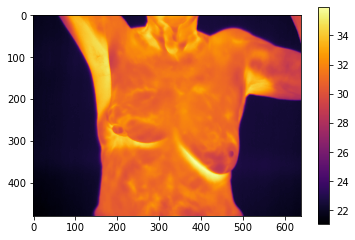

In [4]:
plt.imshow(matrix, cmap="inferno")
plt.colorbar()
plt.show()

In [5]:
img_gray = Image.open("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png")
img_gray = ImageOps.grayscale(img_gray)
img_gray = np.array(img_gray)
print(img_gray.shape, img_gray.dtype, img_gray.min(), img_gray.max())
# print(img_gray.min(), img_gray.max())

(480, 640) uint8 0 222


In [6]:
segmented = np.where(img_gray==0, 0, 1)
segmented = matrix * segmented
print(segmented.shape, segmented.dtype, segmented.min(), segmented.max())

(480, 640) float64 0.0 34.400001525878906


### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

¿Qué es?: https://youtu.be/jF43_wj_DCQ?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN&t=53

In [34]:
"""
Constante encontrada al iterar por todas las imágenes segmentadas, 
calcular su valor máximo de temperatura y devolver el máximo de todas.
"""

MAX_TEMPERATURE = 36.44

In [35]:
class ThermalDataset(Dataset):
  def __init__(self, image_dir: str, matrix_dir: str, transform = None, normalize = None):
    self.image_dir = image_dir
    self.matrix_dir = matrix_dir
    self.transform = transform
    self.normalize = normalize
    self.images = os.listdir(image_dir) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos la imagen de la lista
    img_path = os.path.join(self.image_dir, self.images[index])

    # Leemos la imagen segmentada en escala de grises
    img = Image.open(img_path)
    img = ImageOps.grayscale(img)
    img = np.array(img)

    """ Carga de la matrix """

    # Entramos a la carpeta y conseguimos la matrix de la lista.
      # La razon por la que uso la misma lista de imagenes es porque la imagen y la matrix
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ matrizes: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN0.txt """
    """ segmentada: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png """
    
    if '-dir.png' in self.images[index]:
      matrix_path = os.path.join(self.matrix_dir, self.images[index].replace("-dir.png", ".txt"))
    elif '-esq.png' in self.images[index]:
      matrix_path = os.path.join(self.matrix_dir, self.images[index].replace("-esq.png", ".txt"))
      
    matrix = np.loadtxt(matrix_path, dtype=np.float32) # https://www.geeksforgeeks.org/import-text-files-into-numpy-arrays/

    """ Consigo la imagen segmentada con los valores de la matrix """

    segmented = np.where(img==0, 0, 1) # int64
    # segmented = img * matrix
    img = (matrix * segmented).astype(np.float32) # float32, shape (480, 640)

    # Le agrego un canal explícito 
    img = np.expand_dims(img, axis=2) # https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html

    if self.normalize:
      img = img / MAX_TEMPERATURE

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'DOENTES' 1
    # sino 0.

    label = self.image_dir.split('/')[2]
    if label == 'DOENTES':
      label = 1
    else:
      label = 0

    """ Convertir las imagenes en tensores y hacer resize """
    if self.transform:
      # Aplicamos las transformaciones a la imagen
      # print(type(img), img.shape)
      img = self.transform(img)
      
    return img, label

In [36]:
TEST_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes"
TRAIN_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"

In [37]:
# Primero consigo la ruta de imagenes y matrices para cada uno de los pacientes

dirs_test = []
test_images = 0
test_matrices = 0
for category in os.listdir(TEST_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TEST_PATH, category)):
    # print(os.path.join(TEST_PATH, category, patient))
    dirs_test.append(os.path.join(TEST_PATH, category, patient))
    _, _, files = next(os.walk(os.path.join(TEST_PATH, category, patient, "Segmentadas")))
    # print(files)
    test_images += len(files)
    _, _, files = next(os.walk(os.path.join(TEST_PATH, category, patient, "Matrizes")))
    test_matrices += len(files)


dirs_train = []
train_images = 0
train_matrices = 0
for category in os.listdir(TRAIN_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TRAIN_PATH, category)):
    # print(os.path.join(TRAIN_PATH, category, patient))
    dirs_train.append(os.path.join(TRAIN_PATH, category, patient))
    _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Segmentadas")))
    train_images += len(files)
    try:
      _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Matrizes")))
      train_matrices += len(files)
    except:
      _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Matrizes de Temperatura")))
      train_matrices += len(files)



# Imprimo la cantidad de pacientes y datos que tenemos
print(f"Cantidad de pacientes para testeo: {len(dirs_test)}")
print(f"Cantidad de imagenes para testeo: {test_images}")
print(f"Cantidad de matrices para testeo: {test_matrices}")
print()
print(f"Cantidad de pacientes para entrenamiento: {len(dirs_train)}")
print(f"Cantidad de imagenes para entrenamiento: {train_images}")
print(f"Cantidad de matrices para entrenamiento: {train_matrices}")

Cantidad de pacientes para testeo: 9
Cantidad de imagenes para testeo: 240
Cantidad de matrices para testeo: 180

Cantidad de pacientes para entrenamiento: 47
Cantidad de imagenes para entrenamiento: 1282
Cantidad de matrices para entrenamiento: 948


En teoría por cada paciente tenemos 20 imagenes, pero las cuentas no cuadran, por ejemplo en testeo deberíamos tener 9x20 = 180 imagenes, pero aparecen 240. Esto sucede debido a que hay algunas imagenes que están separadas en la parte izquierda y derecha.

Para el conjunto de entrenamiento tampoco cuadra el número de matrices. Esto es debido a que algunos pacientes tienen una matriz que se llama `ESTATICO` que no tengo ni idea para qué es pero no es problema ya que no hace 'match' con ninguna imágen.

In [38]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES/245/Matrizes/PAC_26_ESTATICO.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
35.02 20.38


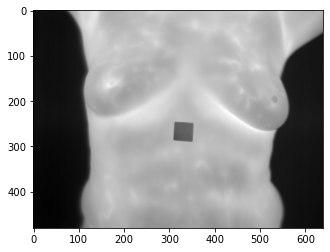

In [39]:
plt.imshow(matrix, cmap='gray')
plt.show()

In [40]:
# Todas las imagenes vienen en h: 480, w: 640. El objetivo es disminuir el tamaño
# sin perder la relación de aspecto. https://gist.github.com/tomvon/ae288482869b495201a0

HEIGHT = 300
r = HEIGHT/480 # Calculo la relación de aspecto. 
WIDTH = int(640*r)
# print(f"Las imagenes son reescaladas a {HEIGHT}x{WIDTH}")

# https://pytorch.org/vision/main/transforms.html#performance-considerations
transform = v2.Compose([  
    v2.ToImage(), 
    # v2.Resize(size=(HEIGHT, WIDTH), antialias=True), 
    # v2.ToDtype(torch.float32),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Para cada paciente armo un dataset y luego con `ConcatDataset` junto todos los pacientes para entrenamiento y para testeo.

In [41]:
test_datasets = []
for patient in dirs_test:
  folders = sorted(os.listdir(patient))
  # print(folders)
  test_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=transform))

In [42]:
train_datasets = []
for patient in dirs_train:
  folders = sorted(os.listdir(patient))
  # print(folders)
  train_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=transform))

In [43]:
# Datasets (concatenate) https://stackoverflow.com/questions/60840500/pytorch-concatenating-datasets-before-using-dataloader
test_dataset = ConcatDataset(test_datasets)
train_dataset = ConcatDataset(train_datasets)

In [44]:
print(test_dataset[4][0].shape, type(test_dataset[4][1]))

torch.Size([1, 480, 640]) <class 'int'>
